In [4]:
# !pip install fairlearn

In [5]:
import numpy as np
import warnings

warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder



from IPython.display import clear_output

np.random.seed(8)

In [6]:
data = pd.read_csv('onlinedeliverydata.csv')
data = data[["Age","Gender", "Marital Status","Occupation", "Monthly Income", "Educational Qualifications",
             "Family size","latitude", "longitude", "Pin code", "Output"]]
print(data.shape)
print(data.info())

(388, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         388 non-null    int64  
 1   Gender                      388 non-null    object 
 2   Marital Status              388 non-null    object 
 3   Occupation                  388 non-null    object 
 4   Monthly Income              388 non-null    object 
 5   Educational Qualifications  388 non-null    object 
 6   Family size                 388 non-null    int64  
 7   latitude                    388 non-null    float64
 8   longitude                   388 non-null    float64
 9   Pin code                    388 non-null    int64  
 10  Output                      388 non-null    object 
dtypes: float64(2), int64(3), object(6)
memory usage: 33.5+ KB
None


### EDA

In [7]:
data.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,Yes
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,Yes
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,Yes
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,Yes
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,Yes


In [8]:
le = LabelEncoder()
data['Output'] = le.fit_transform(data['Output'])
data.head()

,Age,Gender,Marital Status,Occupation,Monthly Income,Educational Qualifications,Family size,latitude,longitude,Pin code,Output
0,20,Female,Single,Student,No Income,Post Graduate,4,12.9766,77.5993,560001,1
1,24,Female,Single,Student,Below Rs.10000,Graduate,3,12.9770,77.5773,560009,1
2,22,Male,Single,Student,Below Rs.10000,Post Graduate,3,12.9551,77.6593,560017,1
3,22,Female,Single,Student,No Income,Graduate,6,12.9473,77.5616,560019,1
4,22,Male,Single,Student,Below Rs.10000,Post Graduate,4,12.9850,77.5533,560010,1


In [9]:
data['Output'].value_counts() # So baseline accuracy is be 301/(301+87) = 77.57%

Output
1    301
0     87
Name: count, dtype: int64

In [10]:
all_columns = data.columns
plt.figure(figsize=(6, 30))
for i, col in enumerate(all_columns):
    print("\n\n", data[col].value_counts())



 Age
23    73
22    57
25    52
24    50
26    35
21    23
27    21
32    16
28    15
29    14
20     9
30     9
31     8
19     4
18     1
33     1
Name: count, dtype: int64


 Gender
Male      222
Female    166
Name: count, dtype: int64


 Marital Status
Single               268
Married              108
Prefer not to say     12
Name: count, dtype: int64


 Occupation
Student           207
Employee          118
Self Employeed     54
House wife          9
Name: count, dtype: int64


 Monthly Income
No Income          187
25001 to 50000      69
More than 50000     62
10001 to 25000      45
Below Rs.10000      25
Name: count, dtype: int64


 Educational Qualifications
Graduate         177
Post Graduate    174
Ph.D              23
School            12
Uneducated         2
Name: count, dtype: int64


 Family size
3    117
2    101
4     63
5     54
6     29
1     24
Name: count, dtype: int64


 latitude
12.9770    36
12.9783    16
12.9850    14
12.8845    12
12.9369    11
           ..
1

<Figure size 432x2160 with 0 Axes>

In [11]:
drop_cols = ['Pin code']
numerical_cols = ['Age', 'latitude', 'longitude']

# Dropping Pin code due to it's functional dependency with latitude and longitude columns
data = data.drop(columns=drop_cols)
print(data.head())


for i in data.columns:
    print(i)
len(data.columns)

   Age  Gender Marital Status Occupation  Monthly Income  \
0   20  Female         Single    Student       No Income   
1   24  Female         Single    Student  Below Rs.10000   
2   22    Male         Single    Student  Below Rs.10000   
3   22  Female         Single    Student       No Income   
4   22    Male         Single    Student  Below Rs.10000   

  Educational Qualifications  Family size  latitude  longitude  Output  
0              Post Graduate            4   12.9766    77.5993       1  
1                   Graduate            3   12.9770    77.5773       1  
2              Post Graduate            3   12.9551    77.6593       1  
3                   Graduate            6   12.9473    77.5616       1  
4              Post Graduate            4   12.9850    77.5533       1  
Age
Gender
Marital Status
Occupation
Monthly Income
Educational Qualifications
Family size
latitude
longitude
Output


10

In [12]:
# Checking for null values
print((data.isnull().sum()!=0).sum())
data.describe()

0


,Age,Family size,latitude,longitude,Output
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,24.628866,3.280928,12.972058,77.600160,0.775773
std,2.975593,1.351025,0.044489,0.051354,0.417611
min,18.000000,1.000000,12.865200,77.484200,0.000000
25%,23.000000,2.000000,12.936900,77.565275,1.000000
50%,24.000000,3.000000,12.977000,77.592100,1.000000
75%,26.000000,4.000000,12.997025,77.630900,1.000000
max,33.000000,6.000000,13.102000,77.758200,1.000000


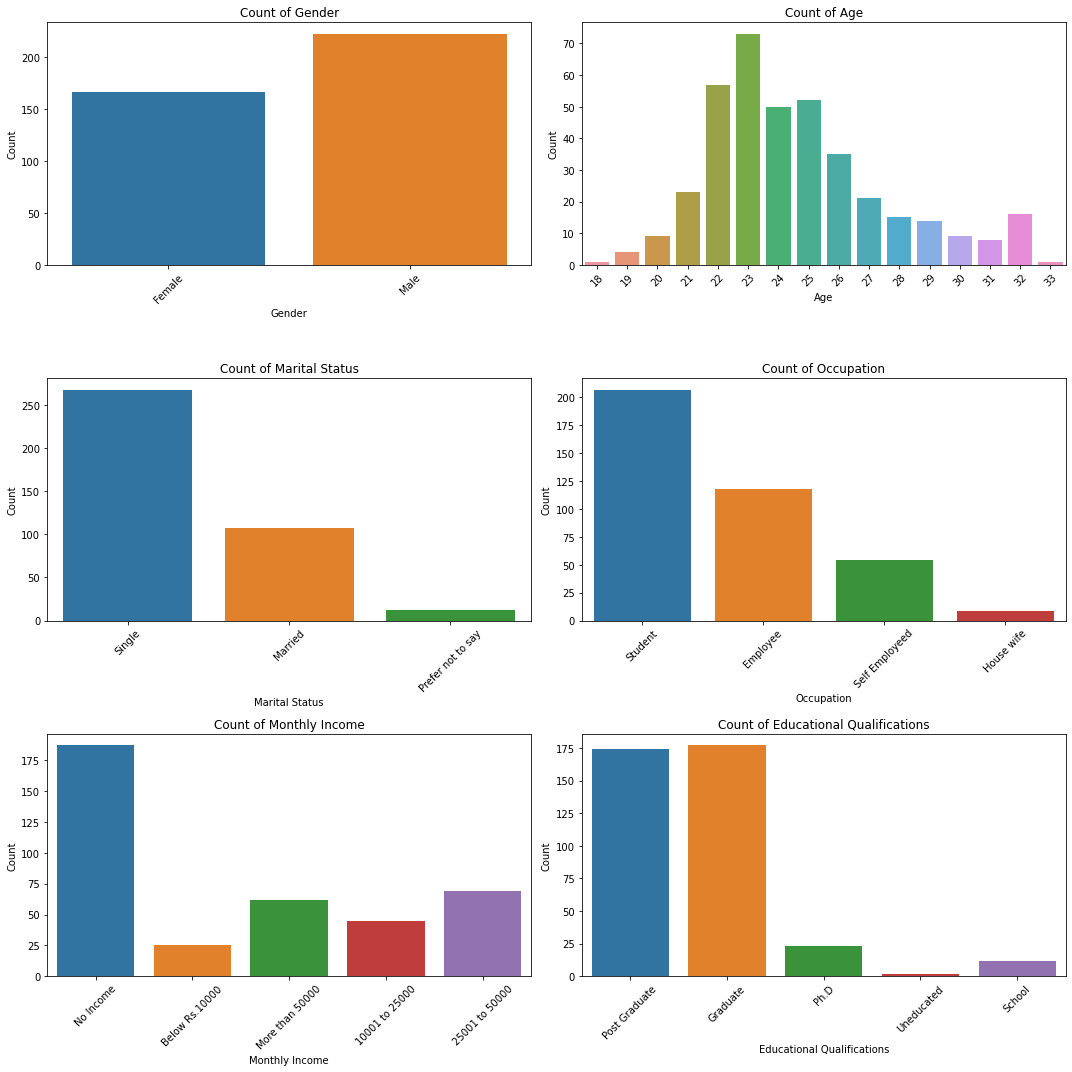

In [13]:
features_to_plot = ['Gender', 'Age', 'Marital Status',
                    'Occupation', 'Monthly Income',
                    'Educational Qualifications']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

for i, feature in enumerate(features_to_plot):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.countplot(data=data, x=feature, ax=ax)
    ax.set_title(f'Count of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Count')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Text(551.8000000000001, 0.5, 'Count')

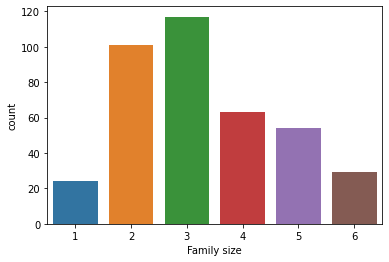

In [14]:
sns.countplot(data=data, x='Family size')
ax.set_title(f'Count of Family size')
ax.set_xlabel('Family size')
ax.set_ylabel('Count')

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

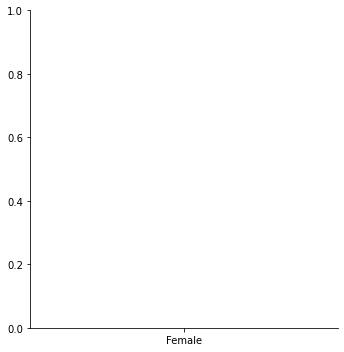

In [15]:
for i, feature in enumerate(features_to_plot):
    sns.displot(data=data, x=feature, hue='Output', multiple='dodge')
    plt.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [16]:
# On-hot encoding of categorical variables
data = pd.get_dummies(data)

In [17]:
data.columns

Index(['Age', 'Family size', 'latitude', 'longitude', 'Output',
       'Gender_Female', 'Gender_Male', 'Marital Status_Married',
       'Marital Status_Prefer not to say', 'Marital Status_Single',
       'Occupation_Employee', 'Occupation_House wife',
       'Occupation_Self Employeed', 'Occupation_Student',
       'Monthly Income_10001 to 25000', 'Monthly Income_25001 to 50000',
       'Monthly Income_Below Rs.10000', 'Monthly Income_More than 50000',
       'Monthly Income_No Income', 'Educational Qualifications_Graduate',
       'Educational Qualifications_Ph.D',
       'Educational Qualifications_Post Graduate',
       'Educational Qualifications_School',
       'Educational Qualifications_Uneducated'],
      dtype='object')

In [18]:
columns = ["Age", "Gender_Male", 'Marital Status_Single', 'Marital Status_Married', 'Occupation_Employee', "Occupation_Student", 'Occupation_Employee', 'Monthly Income_No Income',  'Monthly Income_10001 to 25000', 'Monthly Income_25001 to 50000', 'Monthly Income_Below Rs.10000', 'Educational Qualifications_Ph.D', 'Educational Qualifications_Post Graduate', 'Educational Qualifications_School', 'Educational Qualifications_Uneducated', 'longitude', 'latitude', 'Output']
corr_data = data[columns]

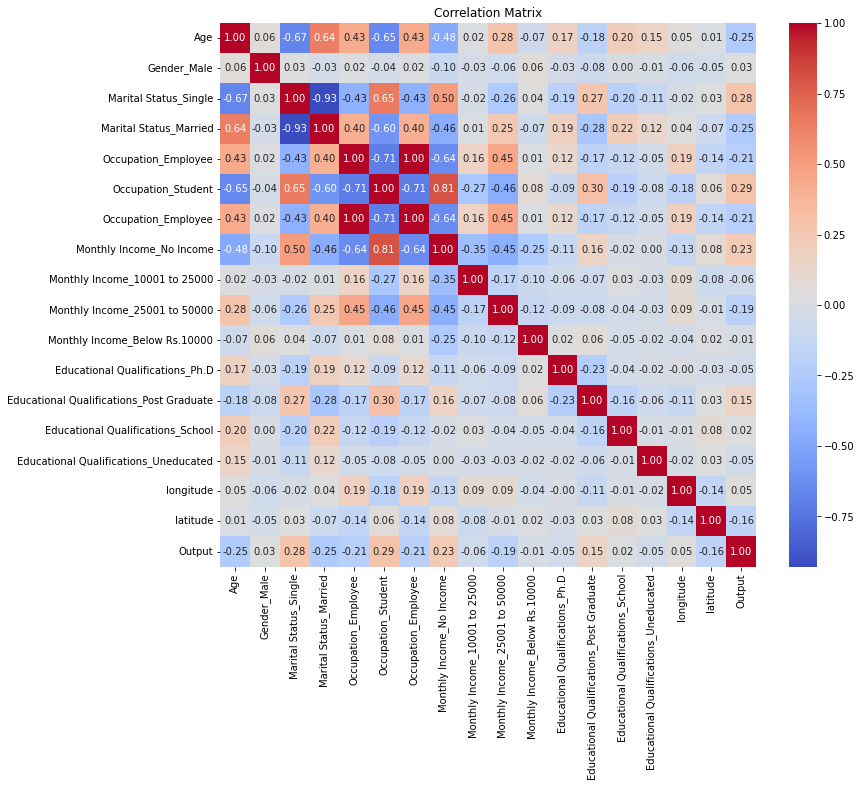

In [19]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_data.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

### Modeling

In [20]:
X = data.drop(['Output', 'Marital Status_Prefer not to say'], axis=1)
y = data['Output']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=101)

print("Shape of train dataset : ", X_train.shape)
print("Shape of test dataset : ", X_test.shape)

Shape of train dataset :  (271, 22)
Shape of test dataset :  (117, 22)


In [21]:
rfc = RandomForestClassifier(n_estimators=100)

rfc.fit(X_train, y_train)

print(rfc.score(X_test, y_test))
y_train.value_counts()

0.8803418803418803


Output
1    211
0     60
Name: count, dtype: int64

In [22]:
# Hyperparameter tuning
max_depth = [3, 5, 7, 9, 12, 20]
n_estimators = [50, 100, 500, 1000, 2000]
min_samples_split = [5, 10]

rfc_model = RandomForestClassifier()
params = {"max_depth": max_depth, "n_estimators": n_estimators, 'min_samples_split':min_samples_split}

# accuracy
tuning = GridSearchCV(rfc_model, params, scoring='accuracy', verbose=1)
tuning.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9, 12, 20],
                         'min_samples_split': [5, 10],
                         'n_estimators': [50, 100, 500, 1000, 2000]},
             scoring='accuracy', verbose=1)

In [23]:
best_model = tuning.best_estimator_
print(tuning.best_params_)

{'max_depth': 12, 'min_samples_split': 5, 'n_estimators': 50}


In [24]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.30      0.42        27
           1       0.82      0.97      0.89        90

    accuracy                           0.81       117
   macro avg       0.77      0.63      0.65       117
weighted avg       0.80      0.81      0.78       117

0.811965811965812
[[ 8 19]
 [ 3 87]]


### Fairness Audit

In [25]:
from fairlearn.metrics import *

### Gender

In [27]:
#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['Gender_Male'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['Gender_Male'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

#compute selection rate for males and females
male_selection_rate = selection_rate(y_test[X_test['Gender_Male']==1], y_pred[X_test['Gender_Male']==1])
female_selection_rate = selection_rate(y_test[X_test['Gender_Male']==0], y_pred[X_test['Gender_Male']==0])

print(f'Male selection rate: {male_selection_rate:.4f}')
print(f'Female selection rate: {female_selection_rate:.4f}')

Demographic parity difference: 0.0879
Demographic parity ratio: 0.9067
Male selection rate: 0.9420
Female selection rate: 0.8542


In [28]:
print(equalized_odds_difference(y_test,
                               y_pred,
                               sensitive_features= X_test['Gender_Male']))

0.38888888888888895


In [29]:
sensitive_feature_sex = X_test['Gender_Male'].replace({1:'male', 0:'female'})

#evaluation metrics
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate, 
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_sex = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_sex)

In [30]:
grouped_on_sex.overall

accuracy          0.811966
selection_rate    0.905983
FNR               0.033333
FPR               0.703704
dtype: float64

In [31]:
grouped_on_sex.by_group

,accuracy,selection_rate,FNR,FPR
Gender_Male,,,,
False,0.875000,0.854167,0.051282,0.444444
True,0.768116,0.942029,0.019608,0.833333


<AxesSubplot:title={'center':'Accuracy and selection rate by sex'}, xlabel='Gender_Male'>

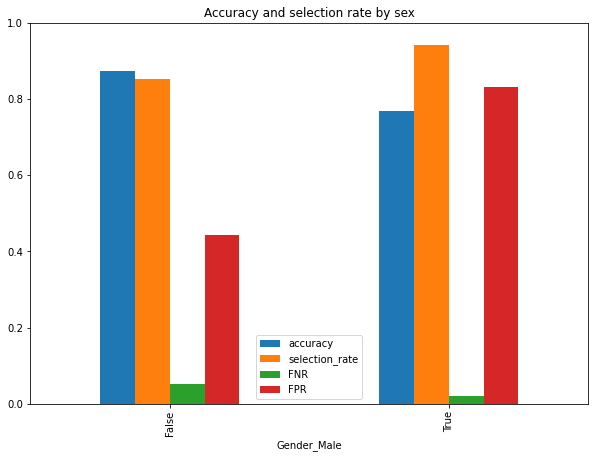

In [32]:
grouped_on_sex.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by sex",
    )

### Marital Status

In [34]:
#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['Marital Status_Single'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['Marital Status_Single'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

#compute selection rate for singles and married
single_selection_rate = selection_rate(y_test[X_test['Marital Status_Single']==1], y_pred[X_test['Marital Status_Single']==1])
married_selection_rate = selection_rate(y_test[X_test['Marital Status_Single']==0], y_pred[X_test['Marital Status_Single']==0])

print(f'Single selection rate: {single_selection_rate:.4f}')
print(f'Married selection rate: {married_selection_rate:.4f}')

Demographic parity difference: 0.1920
Demographic parity ratio: 0.8007
Single selection rate: 0.9634
Married selection rate: 0.7714


In [35]:
print(equalized_odds_difference(y_test,
                               y_pred,
                               sensitive_features= X_test['Marital Status_Single']))

0.1428571428571429


In [36]:
sensitive_feature_maritalstatus = X_test['Marital Status_Single']

#evaluation metrics
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,  
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_maritalstatus = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                        sensitive_features=sensitive_feature_maritalstatus)

In [37]:
grouped_on_maritalstatus.by_group

,accuracy,selection_rate,FNR,FPR
Marital Status_Single,,,,
False,0.657143,0.771429,0.142857,0.642857
True,0.878049,0.963415,0.000000,0.769231


<AxesSubplot:title={'center':'Accuracy and selection rate by marital status'}, xlabel='Marital Status_Single'>

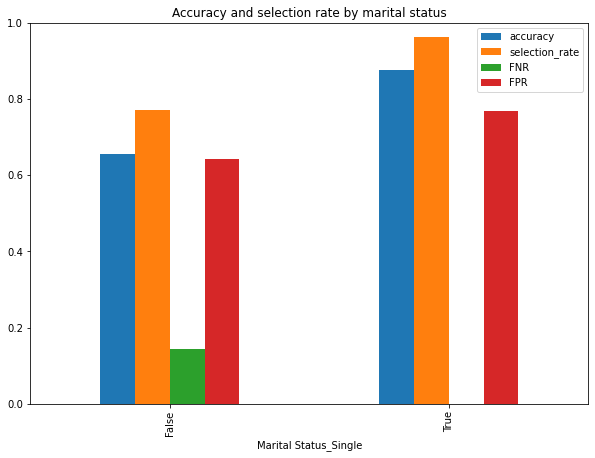

In [38]:
grouped_on_maritalstatus.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by marital status",
    )

### Monthly Income

In [40]:
#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test['Monthly Income_No Income'])
demo_parity_ratio = demographic_parity_ratio(y_test, y_pred, sensitive_features=X_test['Monthly Income_No Income'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

#compute selection rate for singles and married
noIncome_selection_rate = selection_rate(y_test[X_test['Monthly Income_No Income']==1], y_pred[X_test['Monthly Income_No Income']==1])
Income_selection_rate = selection_rate(y_test[X_test['Monthly Income_No Income']==0], y_pred[X_test['Monthly Income_No Income']==0])

print(f'No Income selection rate: {noIncome_selection_rate:.4f}')
print(f'Income selection rate: {Income_selection_rate:.4f}')

Demographic parity difference: 0.1213
Demographic parity ratio: 0.8745
No Income selection rate: 0.9661
Income selection rate: 0.8448


In [41]:
print(equalized_odds_difference(y_test,
                               y_pred,
                               sensitive_features= X_test['Monthly Income_No Income']))

0.11111111111111116


In [42]:
sensitive_feature_MonthlyIncome = X_test['Monthly Income_No Income']

#evaluation metrics
metrics = {'accuracy': accuracy_score,
           'selection_rate': selection_rate,  
           'FNR': false_negative_rate,
           'FPR': false_positive_rate
           }

grouped_on_MonthlyIncome = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_pred,
                             sensitive_features=sensitive_feature_MonthlyIncome)

In [43]:
grouped_on_MonthlyIncome.by_group

,accuracy,selection_rate,FNR,FPR
Monthly Income_No Income,,,,
False,0.741379,0.844828,0.075,0.666667
True,0.881356,0.966102,0.000,0.777778


<AxesSubplot:title={'center':'Accuracy and selection rate by marital status'}, xlabel='Monthly Income_No Income'>

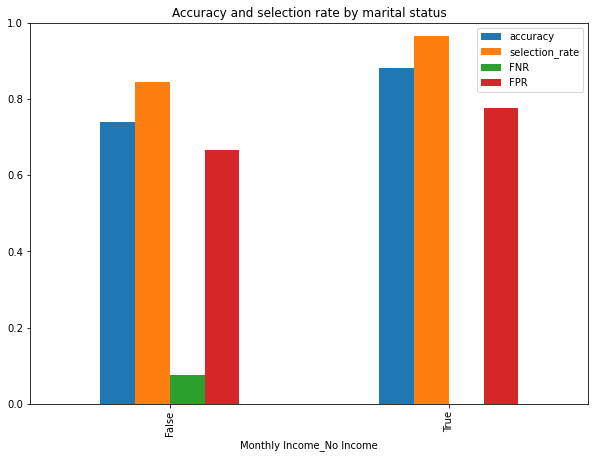

In [44]:
grouped_on_MonthlyIncome.by_group.plot.bar(
    subplots=False,
    figsize=(10, 7),
    ylim=[0,1],
    title="Accuracy and selection rate by marital status",
    )

-------------------

Comparison to Baseline: Model accuracy is only slightly better than baseline (81% vs. 77.57%), indicating minimal learning beyond the predominant class.

Analysis of False Positive Rate (FPR)
A high FPR in the model, especially for certain groups, suggests that the model is prone to predicting the positive class (users opting for online delivery) when the true class is negative. This is indicative of a bias towards predicting more positives, possibly due to the imbalance in the training data where positives are more frequent.

#### Gender Fairness Analysis

Output Imbalance: Majority of predictions are for the positive class, with males having a higher prediction rate for using online delivery. This could be due to the class imbalance in the training data. Both males and females have very high FPR rate with males even higher than females.

Rates: Males have a selection rate of 94.2% vs. females at 85.42%. The demographic parity difference is 0.0879, and the ratio is 0.9067. The equalized odds difference is 0.3889, suggesting significant disparities in both false positive rates and false negative rates across genders, though both the genders have high FPR rates. This indicates that the model has a bias towards males. 

Type of Bias: This is Likely Sampling Bias. The data collection methods inadvertently captured more male responders with higher ratio for positive to negative outcomes than females, which could be skewing results.

Impact of High FPR: Indicates over-prediction of males using the service, leading to potential resource misallocation.

#### Marital Status Fairness Analysis

Output Imbalance: The model predicts a higher likelihood of singles using the service compared to married or other statuses. The fpr rates are again very high for both the demographic groups, with fnr 0 for singles and at 14.3% for non singles.

Rates: Singles are selected at a rate of 96.34% vs. married at 77.14%. The demographic parity difference is 0.1920, and the ratio is 0.8007, showing a bias towards singles. The difference of 0.1429 in this metric further highlights disparities in error rates between singles and married individuals. 

Type of Bias: The marital status by output chart shows a significantly higher number of singles predicted to use online delivery services compared to married individuals or those who prefer not to say. This could be an example of pre existing Bias where the model reflects real-world tendencies of singles perhaps having more need or preference for online services due to lifestyle differences. If singles are more likely to live alone, they might opt for convenience, influencing the model's predictions.

Impact of High FPR: High false positive rate for both the groups means the model often incorrectly predicts they will use the service, which can lead to inefficient marketing. with singles also having 0 fnr with even higher fpr than married people, they would be falsely assumed to have a very high probability of making an online delivery again, leading to the shifted focus onto the married people. Though in this case the high fpr in both groups, could lead to lowered marketing, hence affecting the overall efficiency.

#### Monthly Income Fairness Analysis

Output Imbalance: Those with "No Income" are more frequently predicted to use online delivery services, compared to all those with income as one group, with again both the groups having very high fpr rates. while the fnr rate for noIncome individuals is 0, its 0.075 for those earning an income.

Rates: Individuals with no income are selected more frequently (96.61%) compared to those with an income (84.48%). The demographic parity difference is 0.1213, and the ratio is 0.8745, indicating bias towards those with no income. A difference of 0.1111 in equalized odds shows slight disparities in error rates based on income status.

Type of Bias: This reflects technical bias. The dataset seems to somehow correlates no income with students or young professionals (who might be temporary jobless but still have spending power), making the model learn to associate these features with higher service usage. 

Impact of High FPR: A high rate of false positives among those with income suggests many are incorrectly targeted as service users, leading to potential customer dissatisfaction and wasted resources.

As the majority of training data examples belong to certain classes (like males or singles), the model might be overfitting to these examples, leading to poor generalization to other classes.

## SHAP

In [45]:
import shap

In [46]:
incorrectly_classified = np.where(y_pred != y_test)[0]
correctly_classified = np.where(y_pred == y_test)[0]

In [47]:
# Analyzing model's confidence in misclassified examples
predicted_probabilities = best_model.predict_proba(X_test)
confidence = np.abs(predicted_probabilities[:, 0] - predicted_probabilities[:, 1])

In [48]:
confidence_misclassified = confidence[incorrectly_classified]
len(confidence_misclassified)

22

Text(0, 0.5, 'Frequency')

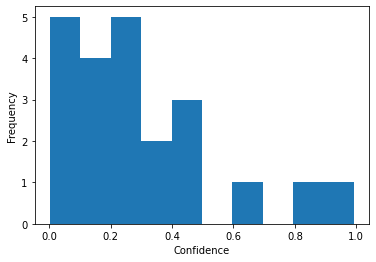

In [49]:
plt.hist(confidence_misclassified)
plt.xlabel('Confidence')
plt.ylabel('Frequency')

In [50]:
# Initialize the explainer
explainer = shap.TreeExplainer(best_model)
# Compute shap values
shap_values = explainer.shap_values(X_test)


In [51]:
print(explainer.expected_value, explainer.expected_value.shape)
shap_values.shape

[0.21933579 0.78066421] (2,)


(117, 22, 2)

In [52]:
shap_values[3].shape

(22, 2)

In [53]:
y_test.values[3]

0

In [56]:
idx = incorrectly_classified[0]
print('Predicted:', y_pred[idx], 'Ground Truth:', y_test.values[idx])
print(X_test.iloc[idx]['Gender_Male'], X_test.iloc[idx]['Marital Status_Single'])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[idx, :, 1], X_test.columns)


Predicted: 1 Ground Truth: 0
True False


In [57]:
idx = incorrectly_classified[1]
print('Predicted:', y_pred[idx], 'Ground Truth:', y_test.values[idx])
print(X_test.iloc[idx]['Gender_Male'], X_test.iloc[idx]['Marital Status_Single'])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[idx, :, 1], X_test.columns)

Predicted: 1 Ground Truth: 0
True False


In [58]:
idx = incorrectly_classified[2]
print('Predicted:', y_pred[idx], 'Ground Truth:', y_test.values[idx])
print(X_test.iloc[idx]['Gender_Male'], X_test.iloc[idx]['Marital Status_Single'])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[idx, :, 1], X_test.columns)

Predicted: 1 Ground Truth: 0
True True


In [59]:
idx = correctly_classified[0]
print('Predicted:', y_pred[idx], 'Ground Truth:', y_test.values[idx])
print(X_test.iloc[idx]['Gender_Male'], X_test.iloc[idx]['Marital Status_Single'])
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[idx, :, 1], X_test.columns)

Predicted: 1 Ground Truth: 1
False True


In [60]:
incorrect_feature_count = {}
incorrect_feature_weight = {}

for idx in incorrectly_classified:
    for feature_idx, shap_val in enumerate(shap_values[idx, :, 1]):
      if ((y_test.values[idx] == 1) and (shap_val < 0)) or ((y_test.values[idx] == 0) and (shap_val >0)):
        if feature_idx not in incorrect_feature_count.keys():
          incorrect_feature_count[feature_idx] = 1
          incorrect_feature_weight[feature_idx] = abs(shap_val)
        else:
          incorrect_feature_count[feature_idx] += 1
          incorrect_feature_weight[feature_idx] += abs(shap_val)

Text(0, 0.5, 'Number of features')

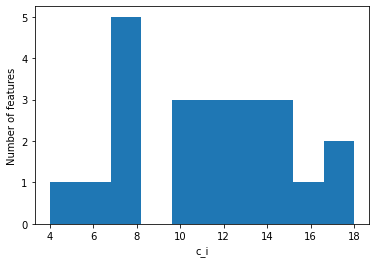

In [61]:
plt.hist(incorrect_feature_count.values())
plt.xlabel('c_i')
plt.ylabel('Number of features')

Text(0, 0.5, 'Number of features')

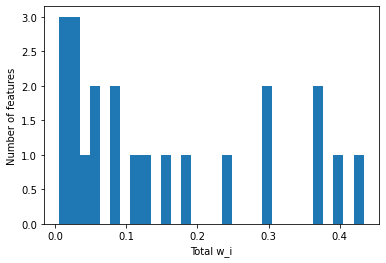

In [62]:
plt.hist(incorrect_feature_weight.values(), bins=30)
plt.xlabel('Total w_i')
plt.ylabel('Number of features')

In [97]:
features_to_remove = []
for feature in incorrect_feature_count:
  if (incorrect_feature_count[feature] > 18) or (incorrect_feature_weight[feature] > 0.4):
    features_to_remove.append(feature)

features_to_keep = []
for i in range(X_train.shape[1]):
  if i not in features_to_remove:
    features_to_keep.append(i)

X_train_improved = X_train.iloc[:, features_to_keep]
X_test_improved = X_test.iloc[:, features_to_keep]


In [98]:
len(features_to_remove)

1

In [99]:
max_depth = [3, 5, 7, 9, 12, 20]
n_estimators = [50, 100, 500, 1000, 2000]
min_samples_split = [5, 10]

rfc_model = RandomForestClassifier()
params = {"max_depth": max_depth, "n_estimators": n_estimators, 'min_samples_split':min_samples_split}

# accuracy
tuning_improved = GridSearchCV(rfc_model, params, scoring='accuracy', verbose=1)
tuning_improved.fit(X_train_improved, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 9, 12, 20],
                         'min_samples_split': [5, 10],
                         'n_estimators': [50, 100, 500, 1000, 2000]},
             scoring='accuracy', verbose=1)

In [100]:
best_model_improved = tuning_improved.best_estimator_
print(tuning_improved.best_params_)

{'max_depth': 7, 'min_samples_split': 10, 'n_estimators': 1000}


In [101]:
y_pred_improved = best_model_improved.predict(X_test_improved)
print(classification_report(y_test, y_pred_improved))
print(accuracy_score(y_test, y_pred_improved))
print(confusion_matrix(y_test, y_pred_improved))

              precision    recall  f1-score   support

           0       0.86      0.22      0.35        27
           1       0.81      0.99      0.89        90

    accuracy                           0.81       117
   macro avg       0.83      0.61      0.62       117
weighted avg       0.82      0.81      0.77       117

0.811965811965812
[[ 6 21]
 [ 1 89]]
